# 라이브러리

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import random
import pingouin as pg

#from ggplot import *
#from scipy.stats import logistic
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import *
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
#import graphviz
#from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from sklearn.svm import SVC, SVR
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


# 한글 폰트 실행
from matplotlib import rcParams
from matplotlib import font_manager,rc
rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
font_name=font_manager.FontProperties(fname='c:/Windows/Fonts/NanumGothic.ttf').get_name()
rc('font',family=font_name)


# 사용자정의함수

## 데이터 용량 조정 함수

In [2]:
import pandas as pd 
import numpy as np

def reduce_mem_usage(df, float16_as32=True):
    # memory_usage()는 데이터프레임의 각 열의 메모리 사용량을 계산하고, sum은 그 값을 합산합니다. B -> KB -> MB로 변환합니다.
    start_mem = df.memory_usage().sum() / 1024**2
    print('데이터프레임의 초기 메모리 사용량은 {:.2f} MB입니다.'.format(start_mem))

    for col in df.columns:  # 각 열의 이름을 반복합니다.
        col_type = df[col].dtype  # 열의 데이터 타입을 가져옵니다.
        if col_type != object and str(col_type) != 'category':  # 객체 타입이 아닌 수치형 변수만 처리합니다.
            c_min, c_max = df[col].min(), df[col].max()  # 해당 열의 최소값과 최대값을 계산합니다.
            if str(col_type)[:3] == 'int':  # 정수형 변수일 경우 (int8, int16, int32, int64 모두 포함)
                # 이 열의 값 범위가 int8의 범위에 있을 경우 타입을 int8로 변환합니다. (-128부터 127까지)
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 이 열의 값 범위가 int16의 범위에 있을 경우 타입을 int16으로 변환합니다. (-32,768부터 32,767까지)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 이 열의 값 범위가 int32의 범위에 있을 경우 타입을 int32로 변환합니다. (-2,147,483,648부터 2,147,483,647까지)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 이 열의 값 범위가 int64의 범위에 있을 경우 타입을 int64로 변환합니다. (-9,223,372,036,854,775,808부터 9,223,372,036,854,775,807까지)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # 실수형일 경우
                # 값이 float16의 범위에 있을 경우 타입을 변환합니다. 더 높은 정밀도가 필요하면 float32를 고려합니다.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:  # 더 높은 정밀도가 필요하면 float32를 선택할 수 있습니다.
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)
                # 값이 float32의 범위에 있을 경우 타입을 float32로 변환합니다.
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 값이 float64의 범위에 있을 경우 타입을 float64로 변환합니다.
                else:
                    df[col] = df[col].astype(np.float64)
    # 최종 메모리 사용량을 계산합니다.
    end_mem = df.memory_usage().sum() / 1024**2
    print('최적화 후 데이터프레임의 메모리 사용량은: {:.2f} MB입니다.'.format(end_mem))
    # 초기 메모리 사용량과 비교하여 몇 퍼센트 감소했는지 계산합니다.
    print('메모리 사용량이 {:.1f}% 감소했습니다.'.format(100 * (start_mem - end_mem) / start_mem))

    return df



import time

def execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Execution time for {func.__name__}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        return result
    return wrapper



@execution_time
def clean_df(data):
    data['고객ID'] = data['고객ID'].astype(str)
    data = reduce_mem_usage(data)
    return data


## 분석 도움 함수

In [3]:
# 재분류
def rename_category_store(df):
    """
    가맹점 업종명을 지정된 카테고리로 재분류하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열에 대해 특정 값들을 지정된 카테고리 이름으로
    대체하여 재분류합니다. 이를 통해 다양한 업종명이 지정된 범주의 카테고리로 통합됩니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점업종명' 열이 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['보습학원', '피부미용실', '골프경기장', '주점', '약 국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['교육/학원', '미용', '스포츠/레저', '외식', '의료/보험']
    
    """
    mapping = {
        '교육/학원': ['보습학원', '예·체능계학원', '외국어학원', '기타 교육기관', '기능학원', '학원', '학습지교육', '초중고교육기관'],
        '미용': ['미용원', '피부미용실'],
        '스포츠/레저': ['기타레져업소', '스포츠·레져용품', '스포츠의류', '스크린골프', '헬스클럽', '골프경기장', '종합레져타운', '골프용품 전문점', '골프연습장', '안마/스포츠마사지', '레져업소', '수 영 장'],
        '여행/교통': ['기타숙박업', '철도', '특급호텔', '1급 호텔', '렌터카', '항공사', '콘도', '2급 호텔', '관광여행', '여객선', '고속버스', '택시'],
        '외식': ['일반한식', '주점', '서양음식', '중국식', '일식·회집', '한정식', '칵테일바', '갈비전문점'],
        '대형마트': ['슈퍼마켓', '농협하나로클럽', '농,축협직영매장', '대형할인점'],
        '백화점': ['면 세 점', '자사카드발행백화점'],
        '편의점': ['편 의 점'],
        '음식료품': ['정육점', '스넥', '농·축·수산품', '농축수산가공품', '주류판매점', '홍삼제품', '인삼제품', '기타건강식품'],
        '카페/베이커리': ['기타음료식품', '제과점'],
        '의료/보험': ['약 국', '의 원', '한 의 원', '치과의원', '기타의료기관 및 기타의료기기', '한약방', '한방병원', '생명보험', '건강진단', '기타보험', '병 원(응급실운영)', '치과병원', '동물병원', '종합병원', '손해보험'],
        '주유': ['SK주유소', '쌍용S-OIL', 'GS주유소', '주유소', 'SK가스충전소', '현대정유(오일뱅크)', 'GS가스충전소', '쌍용S-OIL가스충전소', '현대정유가스충전소', 'E1가스충전소', '전기차충전소'],
        '문화생활': ['문화취미기타', '영화관', '티켓'],
        '이동통신요금': ['이동통신요금'],
        '반려동물': ['애완동물'],
        '간편결제': ['인터넷P/G'],
        '기타': ['전자상거래상품권전문판매', '캐주얼의류', 'CATV', '택시회사', '위성방송', '음반영상물', '제 화','주방용구', '연 쇄 점', '액세서리', '전문서적', '주차장', '민예·공예품', '건축용 요업제품', '단란주점', '옷감·직물', '자동차시트·타이어', '독서실', '농기계', '조명기구', '세차장', '사무서비스', '컴퓨터', '가 방', '보일러·펌프·샷시', '카페트,커튼,천막,지물', '자동차부품', '자동차정비', '기타유통업', '이륜차판매', '카인테리어', '화물운송', '내의판매', '목재·석재·철물', '기타 사무용품', '기타가구', '신 발', '비영리/비대상', '기타대인서비스', '기타전기제품', 'DP&E', '주방용식기', '가타자동차서비스', '기타농업관련', '구내매점(국가기관등)', '아동의류', '이용원', '조세서비스', '기념품점', '유흥주점', '통신기기', '화원', '화장품', '기타잡화', '유아원', 'LPG취급점', '페인트', '출판 및 인쇄물', '귀금속', '문구용품', '위탁급식업', '비료,사료,종자', '침구·수예점', '당구장', '가전제품', '인터넷Mall', '가정용품수리', '사무·통신기기수리', '안경', '세탁소', '사우나', '일반서적', '노 래 방', '기계공구',  '완구점', '기타의류', '미곡상', '기타용역서비스', '기타수리서비스', '기타건축자재', '일반가구', '사무용 OA기기', '인테리어전문', '가례서비스업', '시 계', '비영리/대상', '윤활유전문판매', '정수기', '공공요금대행서비스/소득공제비대상', '화방·표구점', '볼 링 장', '인터넷종합Mall', '기타 전문점', '통신판매업1', '종합용역', '전자상거래상품권', '보관및 창고업', '유류판매', '업종미등록', '통신서비스/소득공제비대상', '기타서적문구', '수족관', '공공요금대행서비스/소득공제대상', '상품권전문판매', '혼례서비스업', '냉열기기', '비씨카드 정산용(할인)', '일반(통신판매)', '기타4', '기타1', '부동산중개·임대', 'CATV홈쇼핑', '소프트웨어', '의료용품', '정장', '맞춤복점', '단체복', '상 품 권', 'PG상품권', '비씨카드 정산용가맹점',  '미용재료']
    }
    for category, values in mapping.items():
        df['가맹점업종명'] = df['가맹점업종명'].replace(values, category)
    print(df['가맹점업종명'].unique())
    return df

def rename_category_store_5(df):
    """
    가맹점 업종명을 미리 정의된 카테고리로 분류하여 새로운 '분류' 컬럼에 추가하는 함수입니다.

    이 함수는 입력된 데이터프레임의 '가맹점업종명' 열의 값들을 사전 정의된 카테고리로 매핑하여,
    각 가맹점이 해당하는 카테고리 정보를 새로운 '분류' 컬럼에 추가합니다. 이를 통해 다양한 업종을
    지정된 범주의 카테고리로 분류하여 분석할 수 있습니다.

    Parameters:
    df (pd.DataFrame): '가맹점업종명' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '분류' 열이 추가된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점업종명': ['백화점', '피부미용실', '골프경기장', '주점', '약국'],
    ...     '승인금액': [10000, 20000, 30000, 40000, 50000]
    ... })
    >>> rename_category_store_5(data)
    가맹점업종명 열을 다음과 같은 카테고리로 재분류합니다: ['쇼핑', '기타', '여가', '기타', '식음료']
    
    Categories:
      - 생활비: ['이동통신요금', '의료/보험', '교육/학원', '반려동물', '주유', '미용']
      - 식음료: ['외식', '카페/베이커리', '음식료품']
      - 쇼핑: ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트']
      - 여가: ['스포츠/레저', '여행/교통', '문화생활']
      - 기타: ['기타']
    
    """
    
    mapping = {
       '생활비' : ['이동통신요금', '의료/보험' , '교육/학원', '반려동물', '주유', '미용'],
        '식음료' : ['외식', '카페/베이커리', '음식료품'],
        '쇼핑' : ['백화점', '홈쇼핑', '온라인쇼핑', '간편결제', '편의점', '대형마트'],
        '여가' : ['스포츠/레저', '여행/교통', '문화생활'],
        '기타' : ['기타']
    }
 
    df['분류'] = df['가맹점업종명']
    for category, values in mapping.items():
        df.loc[df['가맹점업종명'].isin(values), '분류'] = category

    print(df['분류'].unique())
    return df


def rename_category_region(df):
    """
    가맹점 위치의 광역시도를 지정된 지역권으로 재분류하는 함수입니다.

    이 함수는 데이터프레임의 '가맹점_광역시도' 열에 대해 지역별 분류를 수행하여,
    수도권, 영남권, 충청권, 호남권, 강원·제주권으로 대체합니다.

    Parameters:
    df (pd.DataFrame): '가맹점_광역시도' 열을 포함한 데이터프레임.

    Returns:
    pd.DataFrame: '가맹점_광역시도' 열이 지역권으로 재분류된 데이터프레임.

    Example:
    >>> data = pd.DataFrame({
    ...     '가맹점_광역시도': ['서울특별시', '부산광역시', '제주특별자치도', '경기도', '대전광역시'],
    ...     '승인금액': [10000, 20000, 15000, 5000, 3000]
    ... })
    >>> rename_category_region(data)
    '가맹점_광역시도' 열을 다음과 같이 재분류합니다: 수도권, 영남권, 강원·제주권, 충청권 등.
    """
    region_groups = {
        '서울특별시': '수도권', '경기도': '수도권', '인천광역시': '수도권',
        '부산광역시': '영남권', '울산광역시': '영남권', '경상남도': '영남권',
        '충청북도': '충청권', '충청남도': '충청권', '대전광역시': '충청권', '세종특별자치시': '충청권',
        '전북특별자치도': '호남권', '전라남도': '호남권', '광주광역시': '호남권',
        '강원특별자치도': '강원·제주권', '제주특별자치도': '강원·제주권'
    }

    df['가맹점_광역시도'] = df['가맹점_광역시도'].replace(region_groups)
    df['가맹점_광역시도'].value_counts()
    return df

def join(df1, df2, key, way):
    """
    두 데이터프레임을 지정된 키와 조인 방식에 따라 병합하는 함수입니다.

    이 함수는 `pd.merge`를 사용하여 두 데이터프레임을 특정 열(`key`)을 기준으로 
    주어진 조인 방식(`way`)에 따라 병합합니다. 병합 결과는 데이터프레임 형식으로 반환됩니다.

    Parameters:
    df1 (pd.DataFrame): 첫 번째 데이터프레임.
    df2 (pd.DataFrame): 두 번째 데이터프레임.
    key (str): 조인할 때 사용할 공통 열의 이름.
    way (str): 조인 방식 (예: 'inner', 'left', 'right', 'outer').

    Returns:
    pd.DataFrame: 지정된 키와 방식으로 병합된 데이터프레임.

    Example:
    >>> df1 = pd.DataFrame({'ID': [1, 2, 3], 'Value1': ['A', 'B', 'C']})
    >>> df2 = pd.DataFrame({'ID': [2, 3, 4], 'Value2': ['X', 'Y', 'Z']})
    >>> join(df1, df2, key='ID', way='inner')
    <class 'pandas.core.frame.DataFrame'>
       ID Value1 Value2
    0   2      B      X
    1   3      C      Y
    """
    df_joined = pd.merge(df1, df2, on=f'{key}', how=f'{way}')
    print(type(df_joined))
    print(df_joined.head(3))
    return df_joined


## 시각화 관련 함수 ( 다 필요한 건 아님 )

In [4]:
def countplot_test(df, feature):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
    ax = sns.countplot(data=df, x=feature, palette="viridis")
    ax.set_title(f" {feature}")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  
            p.get_height() + 0.5,           
            int(p.get_height()),            
            ha='center',      
            fontsize=8    
        )
plt.show()

In [5]:
def simple_boxplots(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(12, 6)) 
    if len(columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(columns):
        sns.boxplot(y=df[col], palette='viridis', ax=axes[i])  
        axes[i].set_title(f'Box Plot of {col}')  
    plt.tight_layout() 
    plt.show()

In [6]:
def age_balance_boxplot(df, age_column, balance_column):
    fig, axes = plt.subplots(figsize=(8, 6))
    ax = sns.boxplot(data=df, x=age_column, y=balance_column, palette="Set2")
    ax.set_title(f"{age_column} 별 {balance_column}")
    ax.set_xlabel(f"{age_column}")
    ax.set_ylabel(f"{balance_column}")
    plt.show()

## 이상치 관련 함수

In [7]:
# 사분위수 활용해서 이상치 개수 구하기
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_outliers = df[df[column] < (Q1 - 1.5 * IQR)]
    upper_outliers = df[df[column] > (Q3 + 1.5 * IQR)]
    outlier_count = lower_outliers.shape[0] + upper_outliers.shape[0]
    print(f"이상치 개수: {outlier_count}")
    return outlier_count

# 데이터불러오기

In [8]:
import pandas as pd
DATA_PATH = './dataset/CARD/'
DATA_PATH_2 = './dataset/CUSTOMER/'
DATA_PATH_3 = './dataset/CC/'
DATA_PATH_4 = './dataset/CC/이전'
#cc_21_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_40(raw).csv', encoding="utf-8-sig")
#cc_21_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_50(raw).csv', encoding="utf-8-sig")
#cc_21_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_21_60(raw).csv', encoding="utf-8-sig")
#cc_22_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_40(raw).csv', encoding="utf-8-sig")
#cc_22_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_50(raw).csv', encoding="utf-8-sig")
#cc_22_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_22_60(raw).csv', encoding="utf-8-sig")
#cc_23_40_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_40(raw).csv', encoding="utf-8-sig")
#cc_23_50_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_50(raw).csv', encoding="utf-8-sig")
#cc_23_60_raw = pd.read_csv(DATA_PATH_3 + 'cc_23_60(raw).csv', encoding="utf-8-sig")
#cc_22_40 = pd.read_csv(DATA_PATH_3 + 'cc_22_40.csv', encoding="utf-8-sig")
#cc_22_50 = pd.read_csv(DATA_PATH_3 + 'cc_22_50.csv', encoding="utf-8-sig")
#cc_22_60 = pd.read_csv(DATA_PATH_3 + 'cc_22_60.csv', encoding="utf-8-sig")

#cc_21_40_n = pd.read_csv(DATA_PATH_3 + 'cc_21_40_n.csv', encoding="utf-8-sig")
#cc_21_50_n = pd.read_csv(DATA_PATH_3 + 'cc_21_50_n.csv', encoding="utf-8-sig")
#cc_21_60_n = pd.read_csv(DATA_PATH_3 + 'cc_21_60_n.csv', encoding="utf-8-sig")

# 이전
#cc_22_40_n = pd.read_csv(DATA_PATH_4 + 'cc_22_40_n.csv', encoding="utf-8-sig")
#cc_22_50_n = pd.read_csv(DATA_PATH_4 + 'cc_22_50_n.csv', encoding="utf-8-sig")
#cc_22_60_n = pd.read_csv(DATA_PATH_4 + 'cc_22_60_n.csv', encoding="utf-8-sig")

#cc_22_n = pd.read_csv(DATA_PATH_4 + 'cc_22_n.csv', encoding="utf-8-sig")


#cc_22_40 = pd.read_csv(DATA_PATH_3 + 'cc_22_40.csv', encoding="utf-8-sig")
#cc_22_50 = pd.read_csv(DATA_PATH_3 + 'cc_22_50.csv', encoding="utf-8-sig")
#cc_22_60 = pd.read_csv(DATA_PATH_3 + 'cc_22_60.csv', encoding="utf-8-sig")

#cc_22_40_r = pd.read_csv(DATA_PATH_3 + 'cc_22_40_r.csv', encoding="utf-8-sig")
#cc_22_50_r = pd.read_csv(DATA_PATH_3 + 'cc_22_50_r.csv', encoding="utf-8-sig")
#cc_22_60_r = pd.read_csv(DATA_PATH_3 + 'cc_22_60_r.csv', encoding="utf-8-sig")

In [9]:
customer_22 = pd.read_csv(DATA_PATH_2 + 'customer_22.csv', encoding="euc-kr")

In [10]:
card_22 = pd.read_csv(DATA_PATH + 'card_22.csv', encoding="utf-8")
# 왠지 euc-kr 인코딩 방식으론 에러가 나서..

# 데이터 확인

In [11]:
card_22.head()

,거래년월,고객ID,가맹점업종명,가맹점_광역시도,가맹점_시군구,승인건수,승인금액
0,202212,3083154411,일반한식,경상북도,경주시,5번이하,20000
1,202212,3557972915,일반한식,경상북도,경주시,5번이하,20000
2,202212,3605837880,일반한식,경상북도,경주시,5번이하,80000
3,202212,3673581980,일반한식,경상북도,경주시,5번이하,20000
4,202212,3913986482,일반한식,경상북도,경주시,5번이하,40000


In [12]:
customer_22.head(2)

,기준년월,고객ID,연령대,성별,고객등급,자택_시도,자택_시군구,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액
0,202212,9999998161,60대이상,여,일반등급,대구광역시,달서구,600000,0,0,0,0,0
1,202212,9999997589,60대이상,남,일반등급,경상북도,경주시,0,0,0,0,0,0


# 데이터 용량 줄이기 
- raw data (customer_연도, card_연도) 는 데이터가 너무 커서, 데이터 용량 줄이는 과정을 거치는 것이 메모리 사용에 좋다.

In [13]:
customer_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21578686 entries, 0 to 21578685
Data columns (total 13 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   기준년월      int64 
 1   고객ID      int64 
 2   연령대       object
 3   성별        object
 4   고객등급      object
 5   자택_시도     object
 6   자택_시군구    object
 7   수신_요구불예금  int64 
 8   수신_거치식예금  int64 
 9   수신_적립식예금  int64 
 10  수신_펀드     int64 
 11  수신_외화예금   int64 
 12  대출금액      int64 
dtypes: int64(8), object(5)
memory usage: 2.1+ GB


In [14]:
customer_22=clean_df(customer_22)
customer_22.info() # 용량 줄었는지(=데이터타입 바뀌었는지) 확인해본다

데이터프레임의 초기 메모리 사용량은 2140.22 MB입니다.
최적화 후 데이터프레임의 메모리 사용량은: 1564.01 MB입니다.
메모리 사용량이 26.9% 감소했습니다.
Execution time for clean_df: 0h 0m 8.96s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21578686 entries, 0 to 21578685
Data columns (total 13 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   기준년월      int32 
 1   고객ID      object
 2   연령대       object
 3   성별        object
 4   고객등급      object
 5   자택_시도     object
 6   자택_시군구    object
 7   수신_요구불예금  int32 
 8   수신_거치식예금  int32 
 9   수신_적립식예금  int32 
 10  수신_펀드     int32 
 11  수신_외화예금   int32 
 12  대출금액      int32 
dtypes: int32(7), object(6)
memory usage: 1.5+ GB


In [15]:
card_22=clean_df(card_22)
card_22.info() # 용량 줄었는지(=데이터타입 바뀌었는지) 확인해본다

데이터프레임의 초기 메모리 사용량은 3361.67 MB입니다.
최적화 후 데이터프레임의 메모리 사용량은: 2881.43 MB입니다.
메모리 사용량이 14.3% 감소했습니다.
Execution time for clean_df: 0h 0m 17.52s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62945850 entries, 0 to 62945849
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   거래년월      int32 
 1   고객ID      object
 2   가맹점업종명    object
 3   가맹점_광역시도  object
 4   가맹점_시군구   object
 5   승인건수      object
 6   승인금액      int32 
dtypes: int32(2), object(5)
memory usage: 2.8+ GB


# 주제 선정 근거 - raw data 시각화

## 자택시도 분포

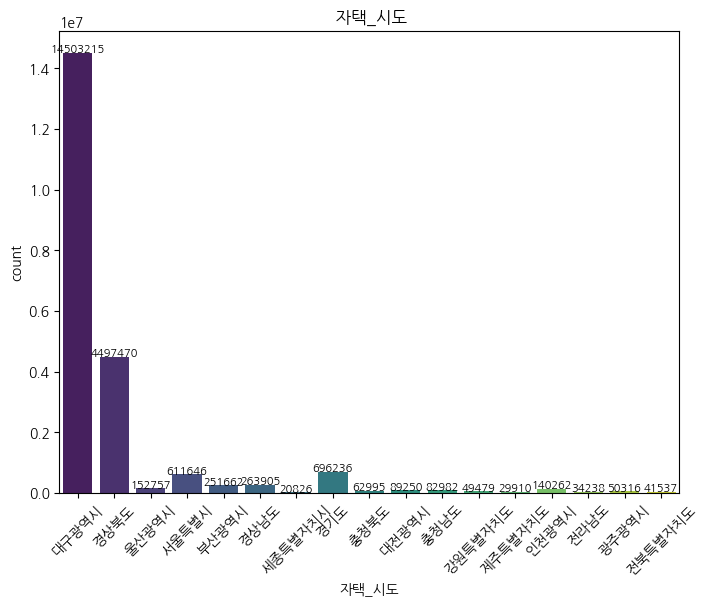

In [17]:
countplot_test(customer_22, '자택_시도')

## 고객 등급 분포

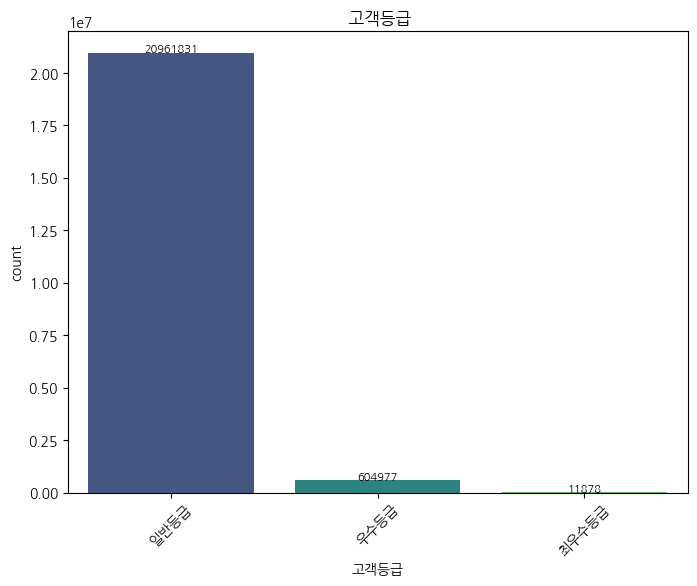

In [18]:
countplot_test(customer_22, '고객등급')

## 성별 분포

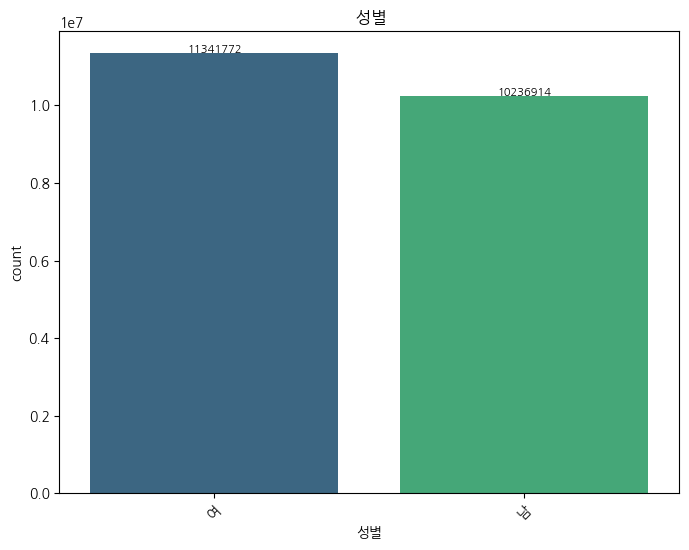

In [19]:
countplot_test(customer_22, '성별')

## 연령대 분포 <- 주제 선정 배경
- 다른 컬럼들과 달리, 연령대는 범주별 차이가 있음을 발견했다.
- 특히 10대 미만에 비해, 40, 50, 60대 이상의 고객이 많다.

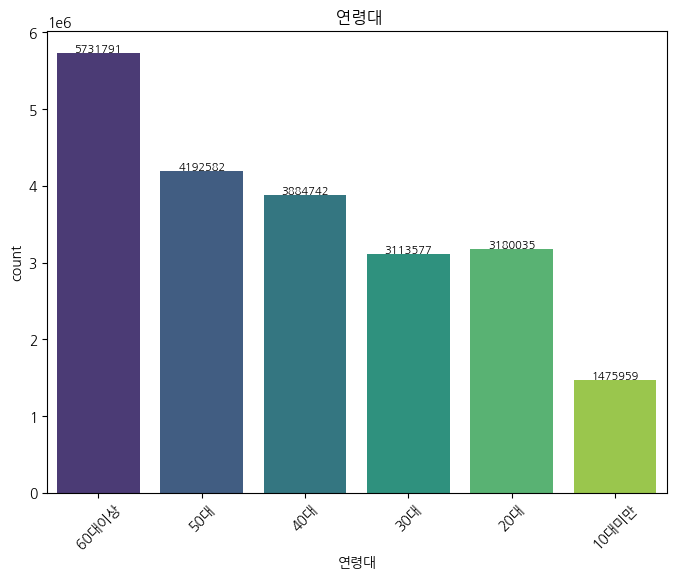

In [21]:
countplot_test(customer_22, '연령대')

## boxplots 한번 그려보기

MemoryError: Unable to allocate 165. MiB for an array with shape (21578686,) and data type int64

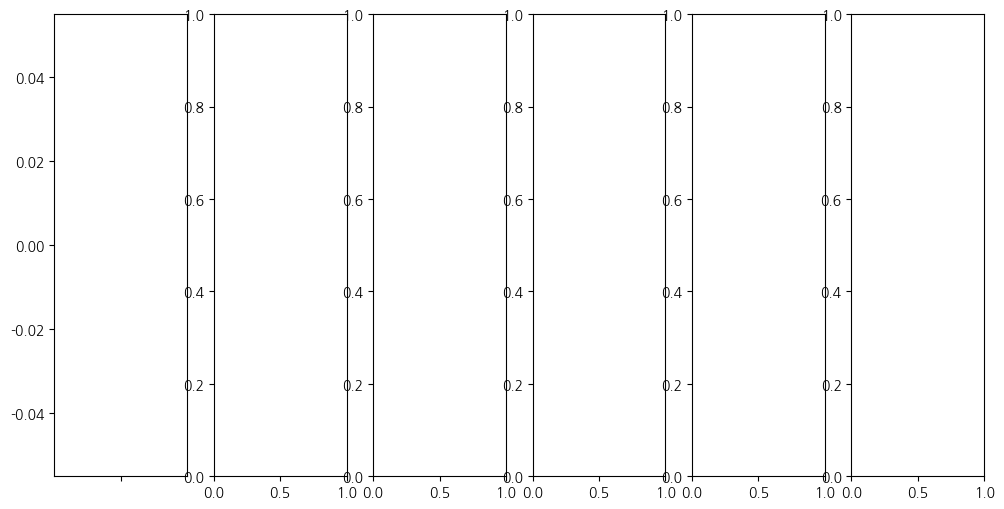

In [22]:
simple_boxplots(customer_22, ['수신_요구불예금'	,'수신_거치식예금',	'수신_적립식예금'	,'수신_펀드'	,'수신_외화예금',	'대출금액'])

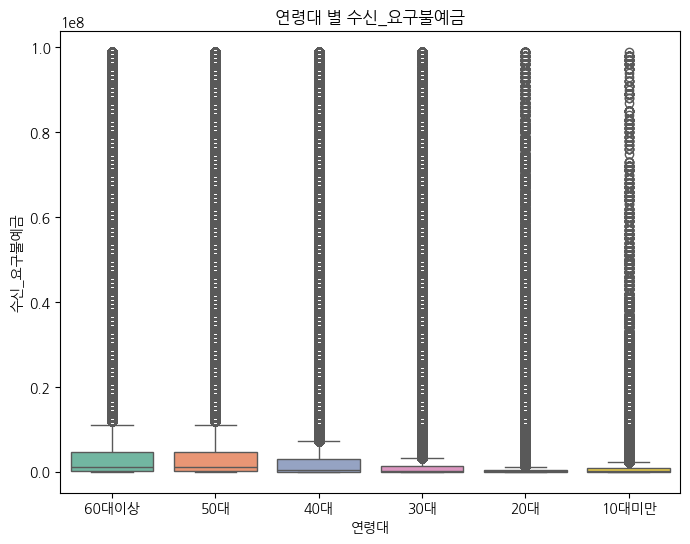

In [20]:
age_balance_boxplot(customer_22, '연령대', '수신_요구불예금')

In [ ]:
age_balance_boxplot(customer_22, '고객등급', '수신_요구불예금')

## 이상치 개수 , 비율 구해보기

In [ ]:
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_outliers = df[df[column] < (Q1 - 1.5 * IQR)]
    upper_outliers = df[df[column] > (Q3 + 1.5 * IQR)]
    outlier_count = lower_outliers.shape[0] + upper_outliers.shape[0]
    print(f"이상치 개수: {outlier_count}")
    return outlier_count

### `수신_요구불예금`에서 이상치 개수, 비율 구하기
- 비율이 매우 높다
- 0 값이 많기 때문일 것으로 추측

In [ ]:
outlier_count = count_outliers(customer_22, '수신_요구불예금')

In [ ]:
total = 20835992
a=20835992 - 2654951
outlier_ratio = a/total
print(f"이상치 비율: {outlier_ratio}")

In [ ]:
# 메모리 에러
# age_balance_boxplot(customer_22, '고객등급', '수신_요구불예금')

# 데이터 전처리

## 이렇게 하면 안됨 -> 다대다 관계 문제 발생

### 고객ID 추출

In [ ]:
customer_22_id = customer_22.loc[:, ['고객ID', '연령대']]
customer_22_id

### 카드 데이터 처리 - 지역, 업종 재분류

In [ ]:
# 지역재분류
temp_card = rename_category_region(card_22)
# 가맹업종명 ㅈ